# Importing packages

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Reading dataset

In [116]:
df = pd.read_csv("a_steam_data_2021_2025.csv")

In [117]:
df.head()

,appid,name,release_year,release_date,genres,categories,price,recommendations,developer,publisher
0,3057270,Seafarer's Gambit,2024,"Jul 5, 2024",Action;Adventure;Indie;RPG;Strategy,Single-player;Family Sharing,3.99,0,Bouncy Rocket Studios,Bouncy Rocket Studios
1,3822840,Capitalist Misadventures,2025,"Jul 25, 2025",Casual;Indie;Simulation;Strategy,Single-player;Save Anytime;Family Sharing,7.99,0,Caramelo Studios,Caramelo Studios
2,3216640,The Beast and the Princess,2025,"Jun 17, 2025",Adventure;Indie;Strategy,Single-player;Steam Achievements;Full controll...,12.99,0,Libragames,Libragames
3,2403620,Air Twister,2023,"Nov 10, 2023",Action;Adventure;Indie,Single-player;Steam Achievements;Full controll...,24.99,0,YS Net,ININ
4,1538040,Horde Slayer,2021,"Mar 19, 2021",Action;Adventure;Casual;Indie;RPG;Early Access,Single-player;Steam Achievements;Full controll...,3.99,0,Wagner Rodrigues,Wagner Rodrigues


# Exploration:

In [118]:
df.describe()

,appid,release_year,price,recommendations
count,6.552100e+04,65521.000000,65521.000000,65521.000000
mean,2.580607e+06,2023.453091,7.204043,362.165336
std,7.692480e+05,1.386641,16.914429,6936.837198
min,1.200220e+06,2021.000000,0.000000,0.000000
25%,1.916970e+06,2022.000000,0.990000,0.000000
50%,2.516050e+06,2024.000000,3.990000,0.000000
75%,3.193800e+06,2025.000000,9.740000,0.000000
max,4.243930e+06,2025.000000,1900.000000,862487.000000


In [119]:
# Information about missing values, which we'll fill in later

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65521 entries, 0 to 65520
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            65521 non-null  int64  
 1   name             65521 non-null  object 
 2   release_year     65521 non-null  int64  
 3   release_date     65521 non-null  object 
 4   genres           65455 non-null  object 
 5   categories       65514 non-null  object 
 6   price            65521 non-null  float64
 7   recommendations  65521 non-null  int64  
 8   developer        65468 non-null  object 
 9   publisher        65338 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 5.0+ MB


In [120]:
# Information about unique values 

df.nunique()

appid              65521
name               65128
release_year           5
release_date        1828
genres              1723
categories          7993
price                589
recommendations     2536
developer          45679
publisher          41600
dtype: int64

In [121]:
# Information about missing values

df.isnull().sum()

appid                0
name                 0
release_year         0
release_date         0
genres              66
categories           7
price                0
recommendations      0
developer           53
publisher          183
dtype: int64

As we can see, there are 1828 unique values in release_date column, but it possibly could be maximum 1826 unique values (365*4+366). And there is no Null value in that column, meaning we have either wrong written release_dates (typos), or another interpretation of date. 

We have to deal with it.

In [122]:
count_for_publisher = df.groupby('publisher')['appid'].count()
print(count_for_publisher.sort_values(ascending=False).head(10))

publisher
EroticGamesClub                    215
BFG Entertainment                  172
8floor                             150
Hede                               142
Kagura Games                       120
Bully Revenge Studios              119
DigiPen Institute of Technology    100
Gamesforgames                       98
indie.io                            93
Do Games Limited                    90
Name: appid, dtype: int64


In [123]:
count_for_genres = df['genres'].value_counts()
print(count_for_genres.head(10))

genres
Casual;Indie               4136
Action;Adventure;Indie     2883
Action;Indie               2632
Adventure;Indie            2325
Casual                     2196
Adventure;Casual;Indie     2056
Action;Casual;Indie        1703
Indie                      1672
Action                     1631
Casual;Indie;Simulation    1456
Name: count, dtype: int64


# Cleaning:

### Checking the problem:

In [124]:
df['release_date_original'] = df['release_date']
df['release_date'] = pd.to_datetime(df['release_date'], format="%b %d, %Y", errors='coerce')

In [125]:
invalid_dates = df[df['release_date'].isna()]

print("Number of invalid dates:", len(invalid_dates))
print(invalid_dates[['release_date']].head())

Number of invalid dates: 1400
    release_date
10           NaT
28           NaT
36           NaT
72           NaT
123          NaT


In [126]:
invalid_dates = df[df['release_date'].isna()]
print(invalid_dates[['release_date_original']])

      release_date_original
10                  Q4 2025
28                  Q4 2025
36                  Q4 2025
72                     2025
123                    2025
...                     ...
65194               Q4 2025
65211               Q4 2025
65289                  2025
65312                  2025
65492                  2025

[1400 rows x 1 columns]


### Solving the problem:

In [127]:
# Function to handle invalid dates
def parse_release_date(date_str):
    if pd.isna(date_str):
        return pd.NaT

    s = str(date_str).strip().upper()

    # Handle quarter formats: Q4 2025 or Q42025
    if s.startswith("Q"):
        q = s[1]                 # quarter number
        year = s[-4:]            # last 4 chars are year
        try:
            period = pd.Period(f"{year}Q{q}", freq="Q")
            return period.start_time
        except:
            return pd.NaT

    # Handle year-only format
    if s.isdigit() and len(s) == 4:
        return pd.to_datetime(f"{s}-01-01")

    # Handle full dates
    return pd.to_datetime(s, errors="coerce")


In [128]:
df['release_date'] = df['release_date_original'].apply(parse_release_date)


In [129]:
df.columns.tolist()

['appid',
 'name',
 'release_year',
 'release_date',
 'genres',
 'categories',
 'price',
 'recommendations',
 'developer',
 'publisher',
 'release_date_original']

In [130]:
df['release_month'] = df['release_date'].dt.month.astype('Int64')
df['release_day']   = df['release_date'].dt.day.astype('Int64')

In [131]:
df.drop(columns=['release_date_original', 'release_date'], inplace=True)

In [132]:
df = df[
    [
        'appid',
        'name',
        'release_year',
        'release_month',
        'release_day',
        'genres',
        'categories',
        'price',
        'recommendations',
        'developer',
        'publisher'
    ]
]


# Visualization:

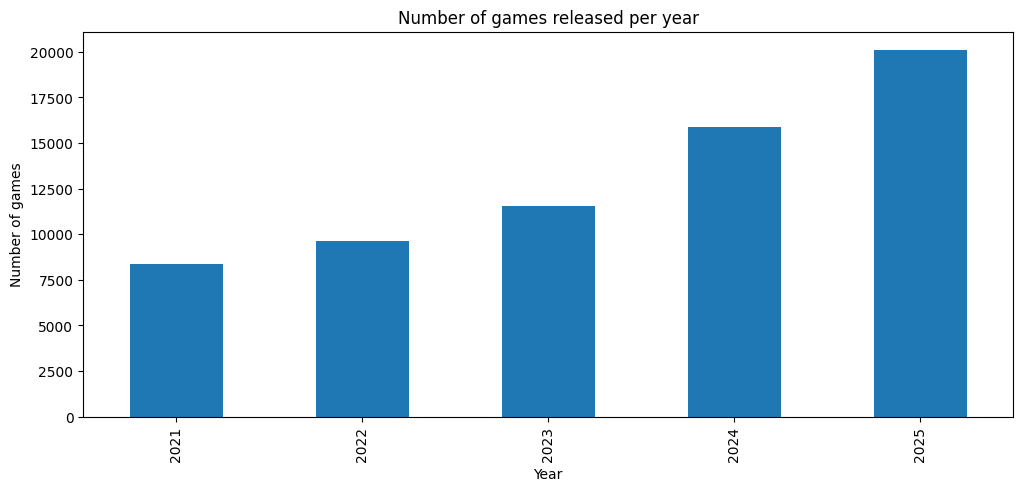

In [133]:
# Number of games per year

df['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
plt.title("Number of games released per year")
plt.xlabel("Year")
plt.ylabel("Number of games")
plt.show()

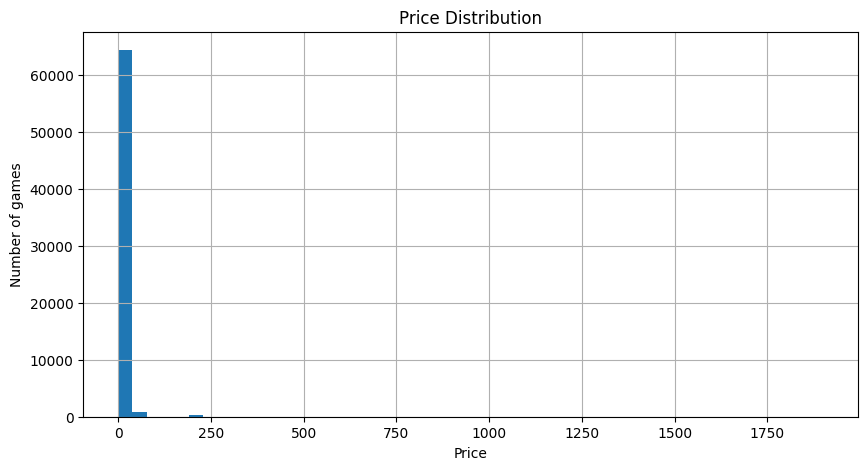

In [134]:
# Price distribution

df['price'].hist(bins=50, figsize=(10,5))
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Number of games")
plt.show()

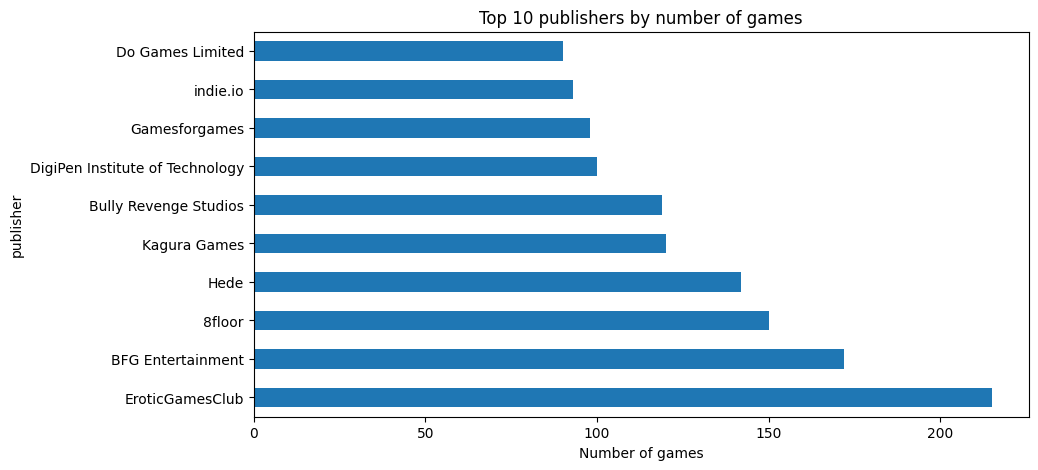

In [135]:
# Top 10 publishers

top_publishers = df['publisher'].value_counts().head(10)
top_publishers.plot(kind='barh', figsize=(10,5))
plt.title("Top 10 publishers by number of games")
plt.xlabel("Number of games")
plt.show()

# Cleaning:

In [136]:
df['price'].fillna(0, inplace=True)
df['recommendations'].fillna(0, inplace=True)

df['price'] = df['price'].astype(float)
df['recommendations'] = df['recommendations'].astype(int)

/tmp/ipykernel_22285/3524332180.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(0, inplace=True)
/tmp/ipykernel_22285/3524332180.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [137]:
df['genres'] = df['genres'].fillna('')

# Feature Engineering:

In [138]:
# Estimating Revenue

df['estimated_revenue'] = df['price'] * df['recommendations']
df[['name','estimated_revenue']].sort_values(by='estimated_revenue', ascending=False).head(10)


,name,estimated_revenue
15892,Black Myth: Wukong,51740595.13
12832,ELDEN RING,47599845.37
49953,Battlefield™ 6,16202125.08
6105,Battlefield™ 2042,15405252.03
51286,Forza Horizon 5,14060036.27
6654,"Warhammer 40,000: Space Marine 2",8334650.66
21428,It Takes Two,7832481.39
12950,Starfield,7749502.77
36391,Palworld,7704894.08
53405,Sons Of The Forest,7475097.47


In [139]:
# Season

def month_to_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Autumn"

df['release_season'] = df['release_month'].astype(int).apply(month_to_season)


In [140]:
df.groupby('release_season')['estimated_revenue'].sum()
df['release_season'].value_counts()


release_season
Autumn    18326
Summer    16101
Spring    15798
Winter    15296
Name: count, dtype: int64

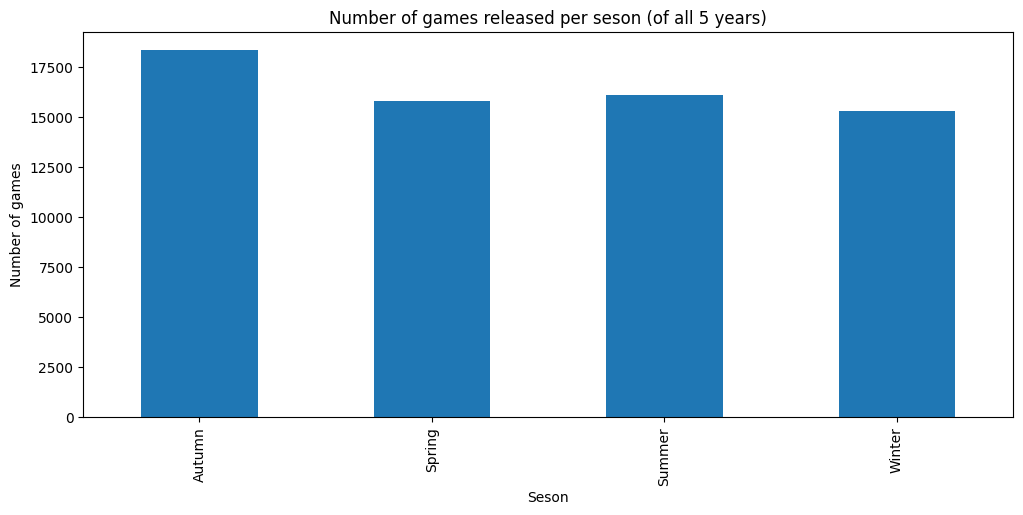

In [141]:
df['release_season'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
plt.title("Number of games released per seson (of all 5 years)")
plt.xlabel("Seson")
plt.ylabel("Number of games")
plt.show()

In [142]:
# Most Popular Genres

df['genres_list'] = df['genres'].str.split(';')

df['num_genres'] = df['genres_list'].apply(len)

In [144]:
from collections import Counter

all_genres = df['genres_list'].sum()  # Flatten all lists into a single list
genre_counts = Counter(all_genres)
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values('count', ascending=False)

In [145]:
print(genre_counts_df)

                    genre  count
2                   Indie  46059
5                  Casual  30710
1               Adventure  26546
0                  Action  25720
6              Simulation  14514
4                Strategy  12995
3                     RPG  12644
8            Free To Play   8043
7            Early Access   6920
9                  Sports   2576
11                 Racing   2350
10  Massively Multiplayer   1382
12                            66
15       Game Development     22
17              Utilities     19
16              Education     15
14  Design & Illustration     12
18   Animation & Modeling     12
13      Software Training     10
21       Video Production      4
19             Accounting      3
20       Audio Production      3
22         Web Publishing      1


/tmp/ipykernel_22285/3633747354.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genre_counts_df, palette='viridis')


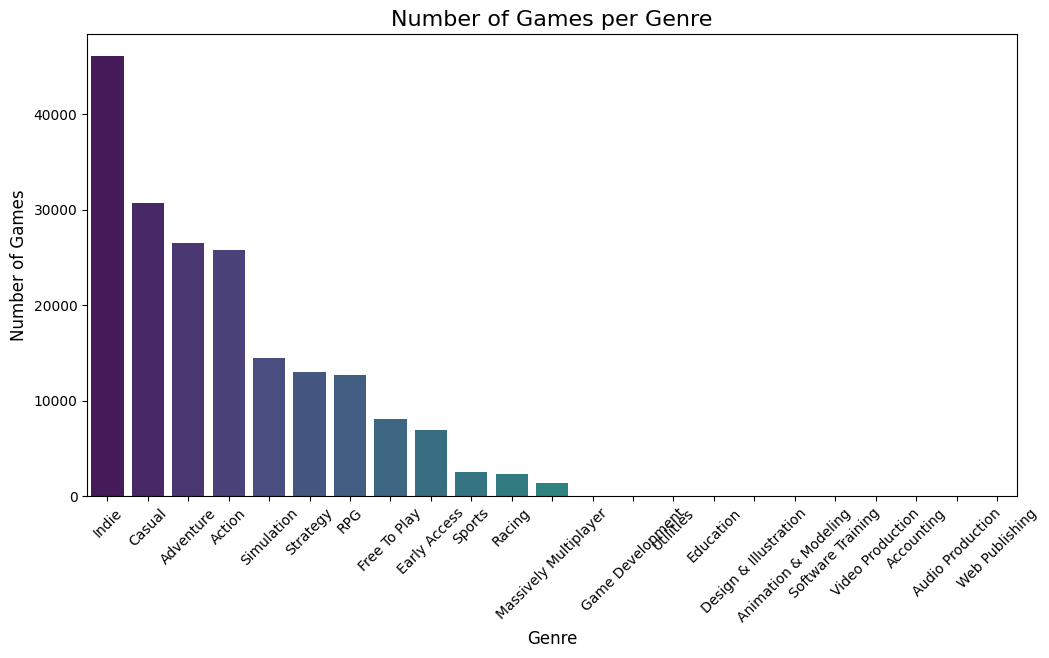

In [146]:
plt.figure(figsize=(12,6))
sns.barplot(x='genre', y='count', data=genre_counts_df, palette='viridis')
plt.title("Number of Games per Genre", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [147]:
df.to_csv("steam_cleaned.csv", index=False)